In [1]:
import matplotlib.pyplot as plt

from scripts import tabular_baselines

import seaborn as sns
import numpy as np

from datasets import load_openml_list, valid_dids_classification, test_dids_classification, open_cc_dids
from scripts.tabular_baselines import *
from scripts.tabular_evaluation import evaluate
from scripts.tabular_metrics import calculate_score, make_ranks_and_wins_table, make_metric_matrix
from scripts import tabular_metrics
from scripts.transformer_prediction_interface import TabPFNClassifier

/anaconda/envs/tabpfn/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from notebook_utils import *

In [3]:
%load_ext autoreload

%autoreload 2

# Datasets

In [4]:
from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids, test_dids_classification

cc_test_datasets_multiclass, cc_test_datasets_multiclass_df = load_openml_list(open_cc_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)


Number of datasets: 30


# Setting params

In [5]:
import os
eval_positions = [1000]
max_features = 100
bptt = 2000
base_path = os.path.join('.')
overwrite = False
#max_times = [0.5, 1, 15, 30, 60, 60*5, 60*15, 60*60]
#max_times = [1, 15]
max_times = [1, 15, 30, 60, 60 * 5, 60 * 15, 60*60]
metric_used = tabular_metrics.auc_metric
task_type = 'multiclass'

In [6]:
from scripts.distill_mlp import DistilledTabPFNMLP
from tabpfn.transformer_make_model import PermutationsMeta, ForwardMLPModel
from functools import partial
from scripts.tabular_baselines import knn_metric, catboost_metric, transformer_metric, logistic_metric, xgb_metric, random_forest_metric, mlp_metric


# Baseline Evaluation
This section runs baselines and saves results locally.

In [7]:
!mkdir -p {base_path}/results
!mkdir -p {base_path}/results/tabular/
!mkdir -p {base_path}/results/tabular/multiclass/

In [8]:
cc_test_datasets_multiclass_df['isNumeric'] = (cc_test_datasets_multiclass_df.NumberOfSymbolicFeatures == 1) & (cc_test_datasets_multiclass_df.NumberOfInstancesWithMissingValues == 0)
name_indexed_dataset = cc_test_datasets_multiclass_df.set_index("name")

#numeric_test_datasets = [ds for ds in cc_test_datasets_multiclass if name_indexed_dataset.loc[ds[0]].isNumeric]
len(name_indexed_dataset)

30

In [9]:
cc_test_datasets_multiclass_df['NumberOfInstances'] =  cc_test_datasets_multiclass_df['NumberOfInstances'].astype(int)
cc_test_datasets_multiclass_df['NumberOfFeatures'] =  cc_test_datasets_multiclass_df['NumberOfFeatures'].astype(int)
cc_test_datasets_multiclass_df['NumberOfClasses'] =  cc_test_datasets_multiclass_df['NumberOfClasses'].astype(int)

print(cc_test_datasets_multiclass_df[['did', 'name', 'NumberOfFeatures', 'NumberOfInstances', 'NumberOfClasses']].to_latex(index=False))

\begin{tabular}{rlrrr}
\toprule
  did &                             name &  NumberOfFeatures &  NumberOfInstances &  NumberOfClasses \\
\midrule
   11 &                    balance-scale &                 5 &                625 &                3 \\
   14 &                    mfeat-fourier &                77 &               2000 &               10 \\
   15 &                         breast-w &                10 &                699 &                2 \\
   16 &                   mfeat-karhunen &                65 &               2000 &               10 \\
   18 &              mfeat-morphological &                 7 &               2000 &               10 \\
   22 &                    mfeat-zernike &                48 &               2000 &               10 \\
   23 &                              cmc &                10 &               1473 &                3 \\
   29 &                  credit-approval &                16 &                690 &                2 \\
   31 &                

In [10]:
import os
os.environ["LD_LIBRARY_PATH"] = "/anaconda/envs/fresh311/lib:" + os.environ["LD_LIBRARY_PATH"]

In [11]:
from tabpfn.scripts.tabular_evaluation import eval_on_datasets
max_times = [1, 5, 15, 60, 5 * 60, 15 * 60, 60* 60]
# these will all be evaluated on CPU because they are given as  callables, which is a weird way to do it.
clf_dict= {
    'knn': knn_metric,
    'rf_new_params': random_forest_metric,
    'xgb': xgb_metric,
    'logistic': logistic_metric,
    'mlp': mlp_metric}

results_baselines = [
    eval_on_datasets('multiclass', model, model_name, cc_test_datasets_multiclass, eval_positions=eval_positions, max_times=max_times,
                     metric_used=metric_used, split_numbers=[1, 2, 3, 4, 5],
                     bptt=bptt, base_path=base_path)
    for model_name, model in clf_dict.items()
]

evaluating knn on cpu


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 525 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating rf_new_params on cpu


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating xgb on cpu


[Parallel(n_jobs=-1)]: Done 175 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating logistic on cpu


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 859 out of 1050 | elapsed:    1.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


evaluating mlp on cpu


[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 859 out of 1050 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    1.4s finished


In [12]:
from tabpfn.scripts.tabular_evaluation import eval_on_datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from tabpfn.transformer_make_model import ShiftClassifier, EnsembleMeta, ForwardMLPModel

# transformers don't have max times
import warnings
max_times = [1]
device = "cpu"

model_string = "defaults_k_aggregate_2_batch_128_onehot_classes_multiclass_02_10_2023_23_55_16"
tabpfn_mine =  TabPFNClassifier(device=device, model_string=model_string, epoch=82, N_ensemble_configurations=32)
#tabpfn_refactor = TabPFNClassifier(device=device, model_string="vanilla_lr0001_new_05_31_2023_23_16_43", epoch=200, N_ensemble_configurations=32)
#tabpfn_refactor_epoch_290 = TabPFNClassifier(device=device, model_string="vanilla_lr0001_new_05_31_2023_23_16_43", epoch=290, N_ensemble_configurations=32)

distilled_tabpfn = DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, )
distilled_tabpfn_one_layer = make_pipeline(StandardScaler(),DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=1, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, ))
distilled_tabpfn_one_layer_no_dropout = make_pipeline(StandardScaler(),DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=1, dropout_rate=0, learning_rate=0.01, model_string=model_string, epoch=82, ))
distilled_tabpfn_two_layer_reproduce2 = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, ))
distilled_tabpfn_one_layer_512_no_dropout = make_pipeline(StandardScaler(),DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=512, n_layers=1, learning_rate=0.001, model_string=model_string, epoch=82, ))
distilled_tabpfn_two_layer_512_no_dropout = make_pipeline(StandardScaler(),DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=512, n_layers=2, learning_rate=0.001, model_string=model_string, epoch=82, ))

distilled_tabpfn_two_layer_reproduce_gpu = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, ))
distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3 = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device=device, hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, N_ensemble_configurations=3))
distilled_tabpfn_two_layer_reproduce_cpu_ensemble_3 = make_pipeline(StandardScaler(), DistilledTabPFNMLP(n_epochs=1000, device="cpu", hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, N_ensemble_configurations=3))



mother_model_string = "models_diff/prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0_epoch_65.cpkt"
forward_mlp = PermutationsMeta(ForwardMLPModel(path=mother_model_string, device=device))
mothernet_new = PermutationsMeta(ForwardMLPModel(path='models_diff/prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0_epoch_on_exit.cpkt'))
mothernet_new_again = PermutationsMeta(ForwardMLPModel(path='models_diff/mothernet_from_scratch_again_06_28_2023_20_51_25_epoch_on_exit.cpkt'))

mothernet_big_model_string = "models_diff/prior_diff_real_checkpointwarm_start_depth_18_model_maker_lr0003_multiclass_05_30_2023_22_53_04_n_0_epoch_49.cpkt"
mothernet_big = PermutationsMeta(ForwardMLPModel(path=mothernet_big_model_string, device=device))

model_string_post_refactor = "models_diff/prior_diff_real_checkpointmothernet_from_scratch_lr0003_warm_start_continue2_multiclass_05_31_2023_19_21_34_n_0_epoch_94.cpkt"
mothernet_post_refactor = PermutationsMeta(ForwardMLPModel(path=model_string_post_refactor, device=device))

model_string_mothernet_small_batches = "models_diff/mothernet_512_everywhere_steps_1024_batch_16_07_02_2023_17_29_55_epoch_on_exit.cpkt"
mothernet_small_batches = PermutationsMeta(ForwardMLPModel(path=model_string_mothernet_small_batches, device=device))


model_string_old_reference_config = "reproduce_reference_config_06_02_2023_17_08_59"
old_reference_config = TabPFNClassifier(device=device, model_string=model_string_old_reference_config, epoch="on_exit", N_ensemble_configurations=32)
old_reference_config_epoch_290 = TabPFNClassifier(device=device, model_string=model_string_old_reference_config, epoch=290, N_ensemble_configurations=32)

model_string_reference_config_continue =  "reproduce_reference_config_continue_06_05_2023_17_45_06"
reference_config_continue = TabPFNClassifier(device=device, model_string=model_string_reference_config_continue, epoch="on_exit", N_ensemble_configurations=32)



model_string_reference_config_long = "reproduce_reference_config_try_again_800_epochs_06_07_2023_21_49_10"
reference_config_long = TabPFNClassifier(device=device, model_string=model_string_reference_config_long, epoch="on_exit", N_ensemble_configurations=32)

perceiver_long = ForwardMLPModel(path="models_diff/perceiver_output_128_emsize_512_nlayers_12_steps_1024_07_01_2023_17_56_04_epoch_690.cpkt", device=device)
perceiver_long_permutations = PermutationsMeta(perceiver_long)

model_string_newest_mlflow = "models_diff/mothernet_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_32a_lr_0.0001_1_gpu_07_19_2023_04_54_38_epoch_1350.cpkt"
mothernet_mlflow_04_54_38 = PermutationsMeta(ForwardMLPModel(path=model_string_newest_mlflow, device=device))

model_string_newest_mlflow_1750 = "models_diff/mothernet_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_32a_lr_0.0001_1_gpu_07_19_2023_04_54_38_epoch_1750.cpkt"
mothernet_mlflow_04_54_38_e1750 = PermutationsMeta(ForwardMLPModel(path=model_string_newest_mlflow_1750, device=device))
mothernet_mlflow_04_54_38_e1750_ensemble = EnsembleMeta(ForwardMLPModel(path=model_string_newest_mlflow_1750, device=device))


#mothernet_tabpfn_preprocessing =  TabPFNClassifier(device=device, model_string="mothernet_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_32a_lr_0.0001_1_gpu_07_19_2023_04_54_38", epoch="1350", N_ensemble_configurations=32)

mothernet_new_old_tabpfn_preprocessing =  TabPFNClassifier(device=device, model_string="prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0", epoch="on_exit", N_ensemble_configurations=32)
mothernet_new_old_ensemble =  EnsembleMeta(ForwardMLPModel(device=device, path="models_diff/prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0_epoch_on_exit.cpkt"), n_estimators=32)

#mothernet_1750_tabpfn_preprocessing =  TabPFNClassifier(device=device, model_string="mothernet_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_32a_lr_0.0001_1_gpu_07_19_2023_04_54_38", epoch="1750", N_ensemble_configurations=32)


perceiver_16_19_18_ensemble =  EnsembleMeta(ForwardMLPModel(device=device, path="models_diff/perceiver_128_emsize_512_nlayers_12_steps_4096_batch_64_lr_3e-05_one_gpu_07_11_2023_16_19_18_epoch_1120.cpkt"), n_estimators=32)

mlflow_validate_str = "tabpfn_128_decoder_1024_emsize_512_nlayers_12_steps_1024_bs_8ada_lr_3e-05_1_gpu_07_21_2023_21_58_32"
mlflow_validate_tabpfn = TabPFNClassifier(device=device, model_string=mlflow_validate_str, epoch="1470", N_ensemble_configurations=32)

#mother_of_ensembles = BaggingClassifier(PermutationsMeta(ForwardMLPModel(path=mother_model_string)), max_features=.8, max_samples=.8)
#mother_of_ensembles_again = BaggingClassifier(PermutationsMeta(ForwardMLPModel(path=mother_model_string)), max_features=.5, max_samples=.5)
forward_mlp_scaled = make_pipeline(StandardScaler(), forward_mlp)
distilled_tabpfn_scaled = make_pipeline(StandardScaler(), distilled_tabpfn)


new_tabpfn_long_e1020 = TabPFNClassifier(device=device, model_string="tabpfn__emsize_512_nlayers_12_steps_2048_bs_32ada_lr_0.0001_1_gpu_07_24_2023_01_43_33", epoch="1020", N_ensemble_configurations=32)
new_tabpfn_long_e1650_ensemble32 = TabPFNClassifier(device=device, model_string="tabpfn__emsize_512_nlayers_12_steps_2048_bs_32ada_lr_0.0001_1_gpu_07_24_2023_01_43_33", epoch="1650", N_ensemble_configurations=32)
new_tabpfn_long_e1650_ensemble3 = TabPFNClassifier(device=device, model_string="tabpfn__emsize_512_nlayers_12_steps_2048_bs_32ada_lr_0.0001_1_gpu_07_24_2023_01_43_33", epoch="1650", N_ensemble_configurations=3)


# large batchsize large learning rate
mothernet_old_config_repro_20_10_21_ensemble = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_512_bs_8192_lr_0.0003_1_gpu_07_28_2023_20_10_21_epoch_2000.cpkt", device=device))
# small batchsize small learning rate
mothernet_new_config_04_14_37_ensemble_e1390 = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_epoch_1390.cpkt", device=device)) 
mothernet_new_config_04_14_37_ensemble_e1520 = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_epoch_1520.cpkt", device=device)) 

mothernet_01_07_16_e1560 = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1560.cpkt", device=device))
mothernet_21_29_51_e5610 = EnsembleMeta(ForwardMLPModel(path="models_diff/mn_n1024_E8000_1_gpu_08_01_2023_21_29_51_epoch_5610.cpkt", device=device))

low_rank_48_19 = EnsembleMeta(ForwardMLPModel(path="models_diff/mn_n1024_L2_W128_P512_1_gpu_08_03_2023_03_48_19_epoch_on_exit.cpkt", device=device))
mothernet_L2_18_33_e780 = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_31_2023_23_18_33_epoch_780.cpkt", device=device))

mothernet_15_46_11_e120 =  EnsembleMeta(ForwardMLPModel(path="models_diff/mn_d1024_H2048_l1e-06_b32_noprenormTrue_1_gpu_warm_08_13_2023_15_46_11_epoch_130.cpkt", device=device))
tabpfn_21_43_17_e760 =  TabPFNClassifier(model_string="tabpfn_n512_l1e-05_b32_mtabpfn_noprenormTrue_1_gpu_warm_08_11_2023_21_43_17", device=device, epoch=760, N_ensemble_configurations=32)
mothernet_01_07_16_e1720 = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device=device))
mothernet_01_07_16_e1720_gpu = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device=device))
mothernet_01_07_16_e1720_gpu_ensemble3 = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device=device), n_estimators=3)
mothernet_01_07_16_e1720_cpu_ensemble3 = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device="cpu"), n_estimators=3)
mothernet_01_07_16_e1720_gpu_ensemble3_gpu_inference = EnsembleMeta(ForwardMLPModel(path="models_diff/mothernet_128_decoder_2048_emsize_512_nlayers_12_steps_8192_bs_8ada_lr_3e-05_1_gpu_07_26_2023_04_14_37_continue_08_12_2023_01_07_16_epoch_1720.cpkt", device=device, inference_device=device), n_estimators=3)
mothernet_05_25_46_e5900 = EnsembleMeta(ForwardMLPModel(path="models_diff/mn_n1024_E8000_d2048_H4096_L2_W128_P512_1_gpu_08_06_2023_05_25_46_epoch_5900.cpkt", device=device))
mothernet_L2_W128_05_25_46_e6550 = EnsembleMeta(ForwardMLPModel(path="models_diff/mn_n1024_E8000_d2048_H4096_L2_W128_P512_1_gpu_08_06_2023_05_25_46_epoch_6550.cpkt", device=device))

mothernet_21_46_25_3940_ensemble3 = EnsembleMeta(ForwardMLPModel(path="mn_d2048_H4096_L2_W32_P512_1_gpu_warm_08_25_2023_21_46_25_epoch_3940_no_optimizer.pickle", device=device), n_estimators=3)


# actually accidentally trained with false due to bug, even if config says true
#reference_config_long.model.efficient_eval_masking = False
clf_dict= {
    
     #        'transformer': transformer_metric,
            'transformer_gpu_timing': TabPFNClassifier(device=device, N_ensemble_configurations=3),
              # 'tabpfn_mine': partial(transformer_metric, classifier=tabpfn_mine),
             #  'tabpfn_post_mlflow': partial(transformer_metric, classifier=mlflow_validate_tabpfn),
          
        'mothernet_01_07_16_e1720_cpu_ensemble3_prescaling': mothernet_01_07_16_e1720_cpu_ensemble3,
    'new_tabpfn_long_e1650_ensemble32': new_tabpfn_long_e1650_ensemble32,
    'new_tabpfn_long_e1650_ensemble3': new_tabpfn_long_e1650_ensemble3,

    'distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3_fixed': distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3,
    'mothernet_01_07_16_e1720_gpu_ensemble3_gpu_inference_fixed': mothernet_01_07_16_e1720_gpu_ensemble3_gpu_inference,
      #  'mothernet_05_25_46_e5900': partial(transformer_metric, classifier=mothernet_05_25_46_e5900),
    #'distilled_tabpfn_two_layer_reproduce_cpu_ensemble_3': distilled_tabpfn_two_layer_reproduce_cpu_ensemble_3,
    #'mothernet_L2_W128_05_25_46_e6550': mothernet_L2_W128_05_25_46_e6550
      #  'mothernet_21_46_25_3940_ensemble3_onehot': partial(transformer_metric, classifier=mothernet_21_46_25_3940_ensemble3, onehot=True),
        'mothernet_21_46_25_3940_ensemble3': partial(transformer_metric, classifier=mothernet_21_46_25_3940_ensemble3)


                  }
results_transformers = [
    eval_on_datasets('multiclass', model, model_name, cc_test_datasets_multiclass, eval_positions=eval_positions, max_times=max_times,
                     metric_used=metric_used, split_numbers=[1, 2, 3, 4, 5],
                     bptt=bptt, base_path=base_path, overwrite=False, n_jobs=-1)
    for model_name, model in clf_dict.items()
]

evaluating transformer_gpu_timing on cpu


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of 150 | elapsed:    3.1s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done 111 out of 150 | elapsed:   16.7s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of 150 | elapsed:    0.2s remaining:    0.6s


evaluating mothernet_01_07_16_e1720_cpu_ensemble3_prescaling on cpu
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device


[Parallel(n_jobs=-1)]: Done 111 out of 150 | elapsed:    7.7s remaining:    2.7s


Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
evaluating new_tabpfn_long_e1650_ensemble32 on cpu


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   10.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
/anaconda/envs/tabpfn/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with

[Parallel(n_jobs=-1)]: Done  35 out of 150 | elapsed:   29.4s remaining:  1.6min


Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device


[Parallel(n_jobs=-1)]: Done 111 out of 150 | elapsed:   34.8s remaining:   12.2s


Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


Using a Transformer with 25.83 M parameters
Using cpu device


[Parallel(n_jobs=-1)]: Done  35 out of 150 | elapsed:    1.9s remaining:    6.2s


Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device


[Parallel(n_jobs=-1)]: Done 111 out of 150 | elapsed:   11.3s remaining:    4.0s


Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   20.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of 150 | elapsed:    1.0s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done 111 out of 150 | elapsed:    8.0s remaining:    2.8s


Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
evaluating mothernet_01_07_16_e1720_gpu_ensemble3_gpu_inference_fixed on cpu


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   20.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of 150 | elapsed:    0.3s remaining:    0.9s


Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device


[Parallel(n_jobs=-1)]: Done 111 out of 150 | elapsed:    6.8s remaining:    2.4s


Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   14.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 59.67 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with

[Parallel(n_jobs=-1)]: Done  35 out of 150 | elapsed:   25.2s remaining:  1.4min


Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 25.83 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transfor

[Parallel(n_jobs=-1)]: Done 111 out of 150 | elapsed:   38.9s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   38.9s finished


In [13]:
# results_baselines = []

Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parameters
Using cpu:0 device
Using a Transformer with 149.66 M parame

In [13]:
flat_results = []
for per_dataset in results_baselines + results_transformers:
    for result in per_dataset:
        row = {}
        for key in ['dataset', 'model', 'mean_metric', 'split', 'max_time']:
            row[key] = result[key]
        best_configs_key, = [k for k in result.keys() if "best_configs" in k]
        if result[best_configs_key][0] is not None:
            row.update(result[best_configs_key][0])
        row['mean_metric'] = float(row["mean_metric"].numpy())
        flat_results.append(row)

results_df = pd.DataFrame(flat_results)

In [14]:
results_df

,dataset,model,mean_metric,split,max_time,best,fit_time,inference_time
0,balance-scale,knn,0.898451,1,1,{'n_neighbors': 14},0.000790,0.031152
1,balance-scale,knn,0.848925,2,1,{'n_neighbors': 8},0.000795,0.026842
2,balance-scale,knn,0.852651,3,1,{'n_neighbors': 10},0.000851,0.027301
3,balance-scale,knn,0.885874,4,1,{'n_neighbors': 10},0.000786,0.028868
4,balance-scale,knn,0.895205,5,1,{'n_neighbors': 15},0.000829,0.027410
...,...,...,...,...,...,...,...,...
6295,climate-model-simulation-crashes,mothernet_21_46_25_3940_ensemble3,0.948417,1,1,NaN,1.672561,0.019185
6296,climate-model-simulation-crashes,mothernet_21_46_25_3940_ensemble3,0.946664,2,1,NaN,1.220246,0.011616
6297,climate-model-simulation-crashes,mothernet_21_46_25_3940_ensemble3,0.938770,3,1,NaN,1.102780,0.014302
6298,climate-model-simulation-crashes,mothernet_21_46_25_3940_ensemble3,0.943767,4,1,NaN,1.500514,0.012872


In [15]:
def remove_device_from_frame(df):    
    res = df.copy()
    res = res[~res.model.str.contains("CPU")]
    res['model'] = res['model'].str.replace(" GPU", "")
    return res

In [16]:
import pickle
with open("results_test_post_refactor.pickle", "wb") as f:
    pickle.dump(results_baselines + results_transformers, f)

In [17]:
results_df.to_csv("results_test_post_refactor.csv")

In [18]:
results_df['model'] = results_df.model.replace({'knn': "KNN", 'rf_new_params': 'RF','mothernet_01_07_16_e1720_cpu_ensemble3_prescaling': 'MotherNet CPU', 'mothernet_01_07_16_e1720_gpu_ensemble3_gpu_inference_fixed': 'MotherNet GPU', 'mlp': "MLP", 'transformer': 'TabPFN GPU', 'transformer_gpu_timing': 'TabPFN GPU','distilled_tabpfn_two_layer_reproduce_gpu_ensemble_3_fixed': 'UTC-Distill GPU', 'xgb':'XGBoost', 'logistic': 'LogReg', 'distilled_tabpfn_two_layer_reproduce_cpu_ensemble_3':'UTC-Distill CPU'})


In [19]:
legend_off = True

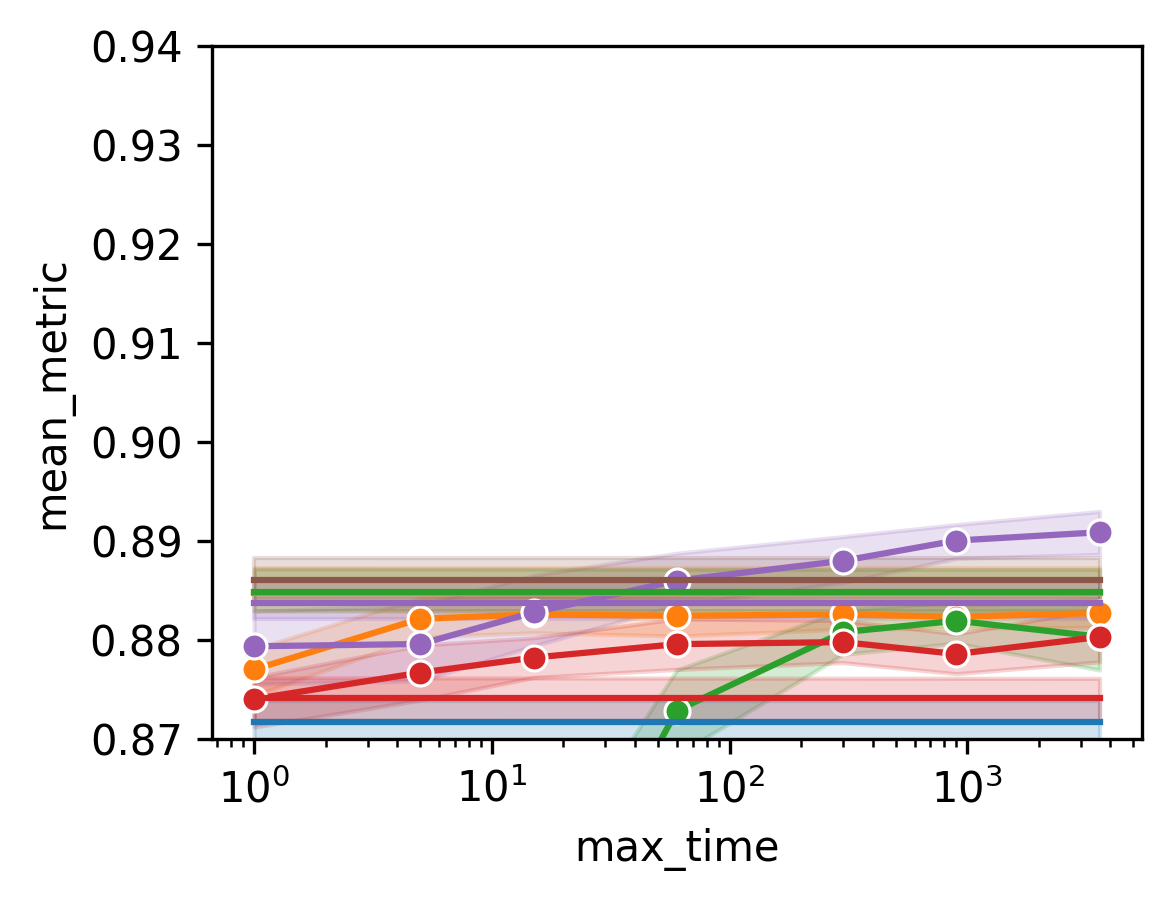

In [21]:
plt.figure(figsize=(4, 3), dpi=300)

compare_splits = remove_device_from_frame(results_df.groupby(["model", "split", "max_time"])['mean_metric'].mean().reset_index())

import seaborn as sns
varies_over_time = ['XGBoost', 'RF', 'MLP', 'KNN', 'LogReg']
compare_splits_varies = compare_splits[compare_splits.model.isin(varies_over_time)]
compare_splits_fixed = compare_splits[~compare_splits.model.isin(varies_over_time)]
hue_order = compare_splits_varies.model.unique().tolist() + compare_splits_fixed.model.unique().tolist()

color_palette = sns.color_palette()
# ax = sns.lineplot(data=compare_splits_varies, x="max_time", y="mean_metric", hue="model", errorbar="sd", marker="o", palette=color_palette[:len(varies_over_time)])#
# ax = sns.lineplot(data=compare_splits_varies, x="max_time", y="mean_metric", hue="model",  marker="o", palette=color_palette[:len(varies_over_time)])
ax = sns.lineplot(data=compare_splits_varies, x="max_time", y="mean_metric", hue="model",  marker="o")

compare_splits_fixed_dummy = compare_splits_fixed.copy()
compare_splits_fixed_dummy['max_time'] = compare_splits_varies.max_time.max()
# sns.lineplot(data=pd.concat([compare_splits_fixed, compare_splits_fixed_dummy]),
#              x="max_time", y="mean_metric", hue="model", ax=ax, palette=color_palette[len(varies_over_time):compare_splits.model.nunique()])
sns.lineplot(data=pd.concat([compare_splits_fixed, compare_splits_fixed_dummy]),
             x="max_time", y="mean_metric", hue="model", ax=ax)
plt.xscale("log")
#legend = plt.legend(loc=(1.1 , .3))
legend = ax.get_legend()
legend.remove()
ax.set_ylim(0.87, 0.94)
plt.savefig("mean_auc_over_time_test_no_legend.pdf", bbox_inches="tight", pad_inches=0.0)

In [22]:
compare_splits_varies_last = compare_splits_varies[compare_splits_varies.max_time == compare_splits_varies.max_time.max()]

<AxesSubplot:xlabel='mean_metric', ylabel='model'>

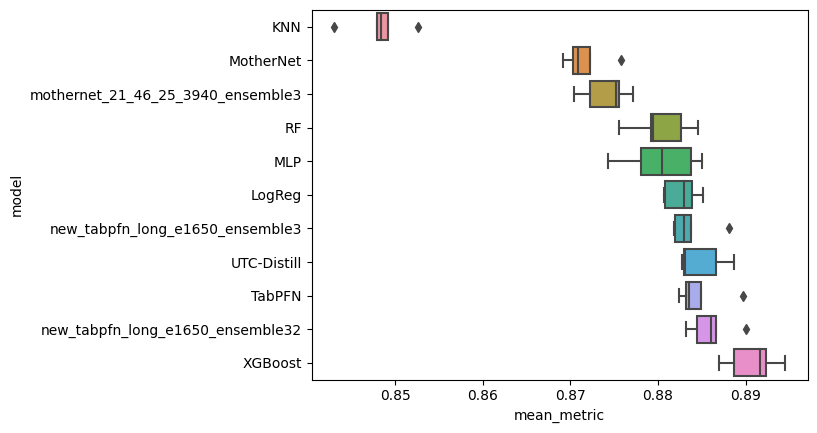

In [23]:
order = pd.concat([compare_splits_fixed, compare_splits_varies_last]).groupby("model").median("mean_metric").sort_values("mean_metric").index
sns.boxplot(data=pd.concat([compare_splits_fixed, compare_splits_varies_last]), y="model", x="mean_metric", order=order)

<AxesSubplot:xlabel='mean_metric', ylabel='model'>

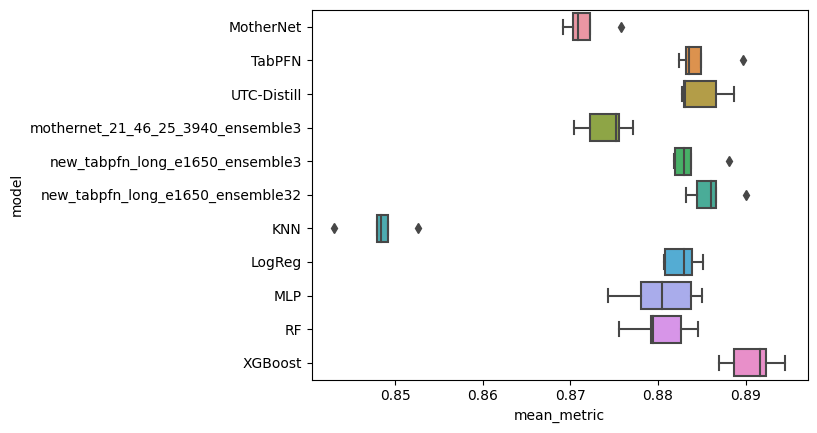

In [24]:
sns.boxplot(data=pd.concat([compare_splits_fixed, compare_splits_varies_last]), y="model", x="mean_metric", hue_order=hue_order)

In [25]:
average_over_splits = results_df.groupby(["dataset", "model", "max_time"])[["mean_metric", "fit_time", "inference_time"]].mean().reset_index()

In [26]:
best_tuned = average_over_splits[average_over_splits.max_time == average_over_splits.max_time.max()]
untuned = average_over_splits[~average_over_splits.model.isin(best_tuned.model.unique())]
combined_best = pd.concat([best_tuned, untuned])

In [27]:
combined_best

,dataset,model,max_time,mean_metric,fit_time,inference_time
6,MiceProtein,KNN,3600,0.997160,0.000310,0.003859
13,MiceProtein,LogReg,3600,0.999254,0.750899,0.000371
20,MiceProtein,MLP,3600,0.999715,9.829015,0.002590
29,MiceProtein,RF,3600,0.999188,0.233837,0.027046
38,MiceProtein,XGBoost,3600,0.999776,14.160225,0.057572
...,...,...,...,...,...,...
1248,wdbc,TabPFN GPU,1,0.996465,0.000261,0.171985
1249,wdbc,UTC-Distill GPU,1,0.994813,3.091072,0.000713
1257,wdbc,mothernet_21_46_25_3940_ensemble3,1,0.996144,1.427393,0.017379
1258,wdbc,new_tabpfn_long_e1650_ensemble3,1,0.996275,0.000311,0.198103


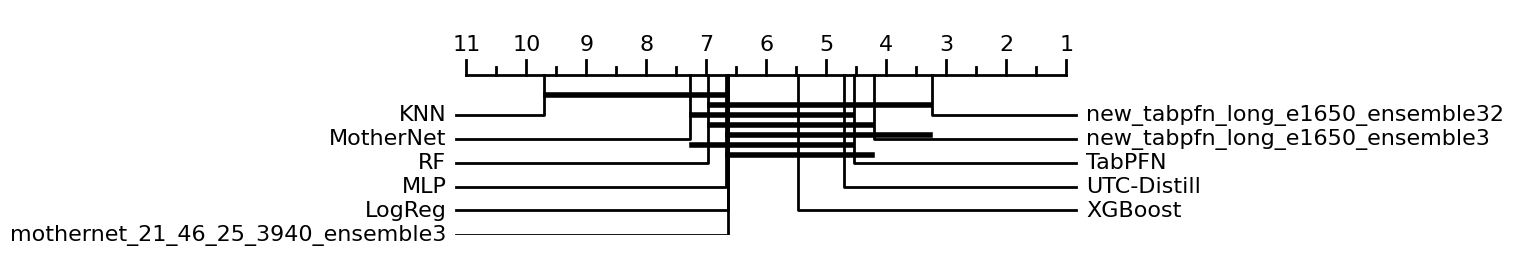

In [28]:
from tabpfn.scripts.critical_differences import draw_cd_diagram
res = draw_cd_diagram(remove_device_from_frame(combined_best), dataset_column="dataset", classifier_column="model", metric_column="mean_metric");
plt.savefig("cd_diagram_test.pdf", bbox_inches="tight", pad_inches=.15)

In [29]:
results_for_ranking = results_df.pivot(index="max_time", columns=["dataset", "split", "model"], values="mean_metric").ffill()

ranks_per_split_per_dataset = results_for_ranking.stack("model").unstack("max_time").rank(ascending=False)
average_ranks = ranks_per_split_per_dataset.stack("dataset").unstack("model").mean().reset_index(name="mean_rank")

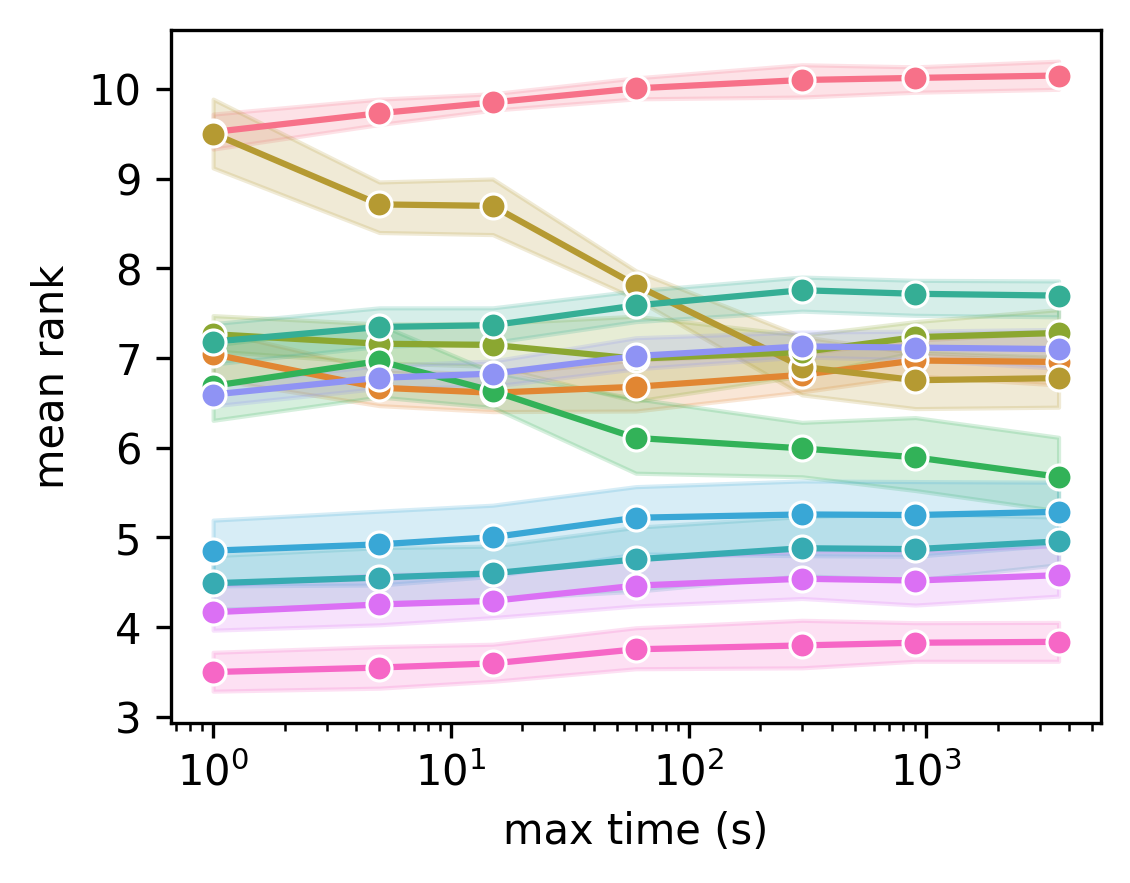

In [30]:
# ax = sns.lineplot(data=average_ranks, x="max_time", y="mean_rank", hue="model", errorbar="sd", marker="o")
plt.figure(figsize=(4, 3), dpi=300)
ax = sns.lineplot(data=remove_device_from_frame(average_ranks), x="max_time", y="mean_rank", hue="model", marker="o", hue_order=hue_order)
ax.set_xscale("log")
#sns.move_legend(ax, (1.01, 0))
ax.set_ylabel("mean rank")
ax.set_xlabel("max time (s)")
legend = plt.legend(loc=(1.1 , .3))
legend.remove()
plt.savefig("rank_over_time_test_numeric_no_legend.pdf", bbox_inches="tight")

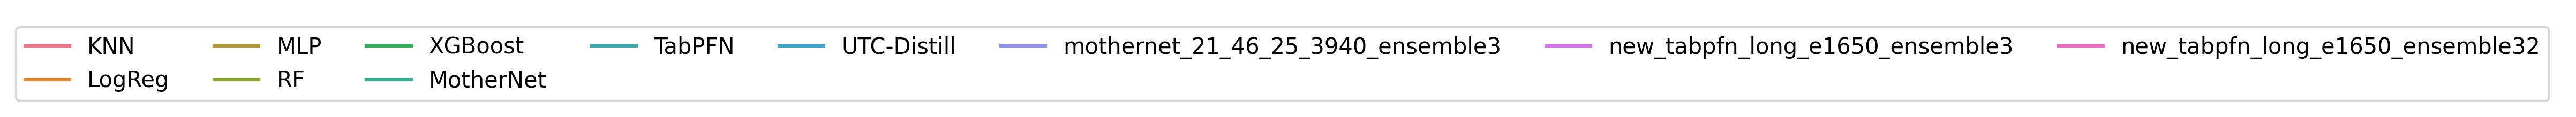

In [31]:
plt.figure(figsize=(10, .2), dpi=300)
ax = plt.gca()
ax.legend(legend.legendHandles, [t.get_text() for t in legend.texts], ncol=8)
ax.set_axis_off()
plt.savefig("legend.pdf", bbox_inches="tight")

NameError: name 'with_tuning' is not defined

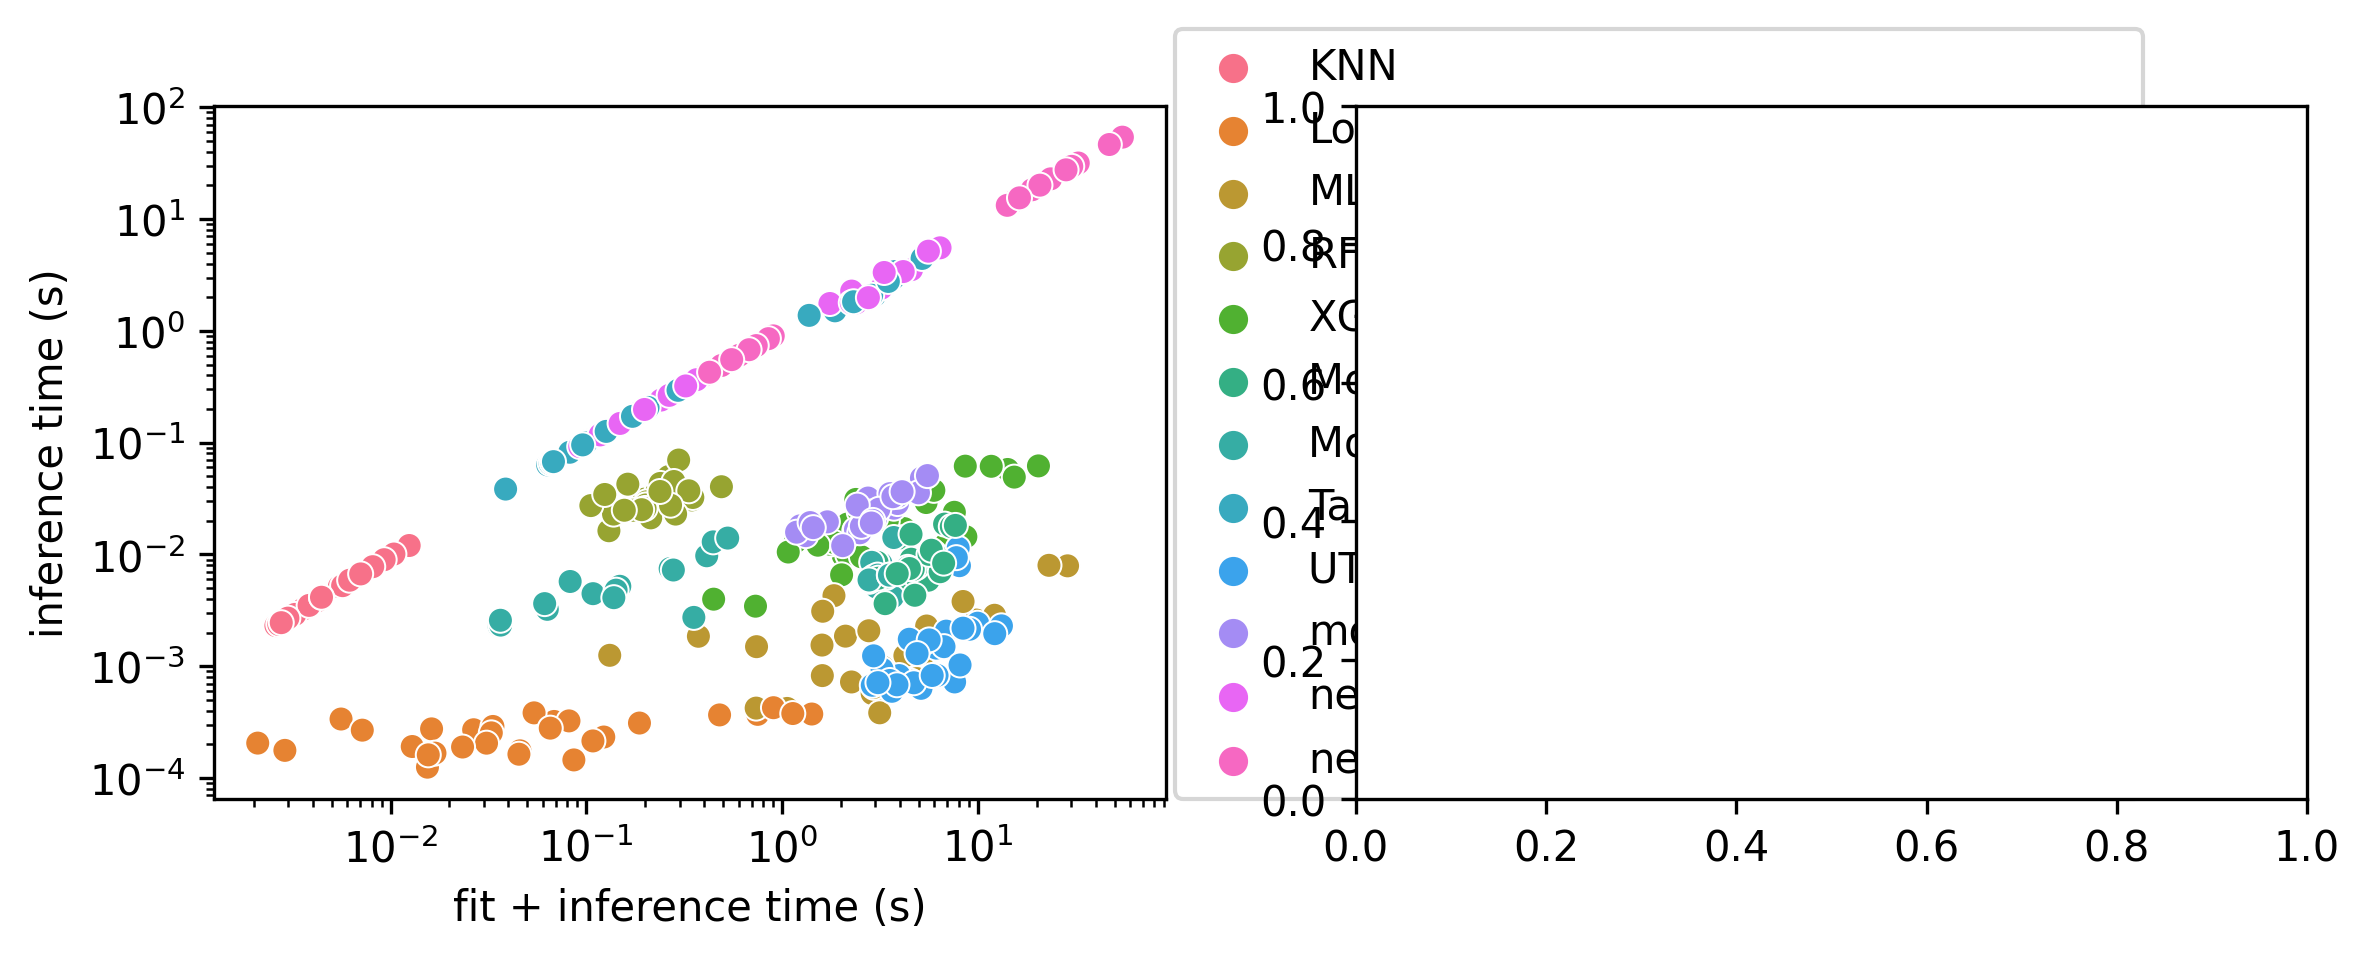

In [32]:

combined_best = pd.concat([best_tuned, untuned])
combined_best = combined_best[~combined_best.model.isin(["tabpfn_post_mlflow", "distill_tabpfn_scaled"])].copy()
max_time = combined_best.max_time.max()

fig, axes = plt.subplots(1, 2, figsize=(9, 3), dpi=300)

combined_best['fit_and_predict_time'] = combined_best['fit_time'] + combined_best['inference_time']

#sns.scatterplot(data=combined_best, y="inference_time", x="fit_and_predict_time", hue="model", ax=axes[0], hue_order=["MotherNet", "TabPFN GPU", 'TabPFN-distill GPU', 'XGBoost', 'MotherNet GPU', "KNN", "LogReg", "RF", "MLP"])
sns.scatterplot(data=combined_best, y="inference_time", x="fit_and_predict_time", hue="model", ax=axes[0])
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_xlabel("fit + inference time (s)")
axes[0].set_ylabel("inference time (s)")
legend = axes[0].legend(loc=(1.01, 0))
#sns.move_legend(axes[0], (1.01, 0))

combined_best['fit_predict_tuning'] = combined_best['fit_and_predict_time'].copy()
#with_tuning = with_tuning[with_tuning.model.isin(["MotherNet", "TabPFN GPU", 'TabPFN-distill GPU', 'XGBoost', 'MotherNet GPU'])]
combined_best.fit_predict_tuning[with_tuning.model == "XGBoost"] = combined_best.fit_and_predict_time[with_tuning.model == "XGBoost"] + 30
combined_best.fit_predict_tuning[with_tuning.model == "MLP"] = combined_best.fit_and_predict_time[with_tuning.model == "MLP"] + 5 * 60
combined_best.fit_predict_tuning[with_tuning.model == "KNN"] = combined_best.fit_and_predict_time[with_tuning.model == "KNN"] + max_time
combined_best.fit_predict_tuning[with_tuning.model == "RF"] = combined_best.fit_and_predict_time[with_tuning.model == "RF"] + max_time
combined_best.fit_predict_tuning[with_tuning.model == "LogReg"] = combined_best.fit_and_predict_time[with_tuning.model == "LogReg"] + 15


#sns.scatterplot(data=with_tuning, y="inference_time", x="fit_and_predict_time", hue="model", ax=axes[1], hue_order=["MotherNet", "TabPFN GPU", 'TabPFN-distill GPU', 'XGBoost', 'MotherNet GPU'])
sns.scatterplot(data=combined_best, y="inference_time", x="fit_predict_tuning", hue="model", ax=axes[1])
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel("fit + inference time + tuning (s)")
axes[1].set_ylabel("inference time (s)")

axes[1].legend().remove()
plt.tight_layout()
plt.savefig("timing_comparison_two_panels_test.pdf")

In [33]:
combined_best.set_index(['dataset', 'model']).unstack("model").fit_and_predict_time

model,KNN,LogReg,MLP,MotherNet CPU,MotherNet GPU,RF,TabPFN GPU,UTC-Distill GPU,XGBoost,mothernet_21_46_25_3940_ensemble3,new_tabpfn_long_e1650_ensemble3,new_tabpfn_long_e1650_ensemble32
dataset,,,,,,,,,,,,
MiceProtein,0.004169,0.751270,9.831605,4.092803,3.726693,0.260883,3.762049,9.988341,14.217797,2.752701,4.590920,32.630304
analcatdata_authorship,0.003403,0.122883,2.110796,4.563804,0.412486,0.245822,0.311527,3.967652,5.450201,2.818956,0.323498,0.490144
analcatdata_dmft,0.002863,0.016207,0.738004,3.294303,3.039054,0.263549,3.304843,5.857927,2.056755,2.355799,2.532151,23.580556
balance-scale,0.002596,0.005586,3.867224,3.509384,0.354518,0.130538,0.038719,3.247113,6.888863,2.374335,0.125737,0.392378
banknote-authentication,0.004147,0.015441,2.265630,5.589303,0.082742,0.137829,0.063518,5.132180,2.159731,3.729743,0.103427,0.287249
blood-transfusion-service-center,0.002833,0.002096,4.294787,4.182153,0.063223,0.197757,0.065382,3.552801,1.168271,1.705686,0.095258,0.151460
breast-w,0.006488,0.007173,1.607487,2.996598,3.232923,0.163053,2.964590,6.149684,1.650767,2.497686,3.215706,19.216158
car,0.005477,0.068510,12.189443,4.866577,4.678196,0.296518,6.392242,13.220129,2.382540,3.559973,6.421048,54.853179
climate-model-simulation-crashes,0.002869,0.012909,6.137090,4.207329,0.035843,0.194027,0.082313,2.937308,2.164923,1.323000,0.114753,0.277785


In [34]:
combined_best.set_index(['dataset', 'model']).unstack("model").fit_predict_tuning

model,KNN,LogReg,MLP,MotherNet CPU,MotherNet GPU,RF,TabPFN GPU,UTC-Distill GPU,XGBoost,mothernet_21_46_25_3940_ensemble3,new_tabpfn_long_e1650_ensemble3,new_tabpfn_long_e1650_ensemble32
dataset,,,,,,,,,,,,
MiceProtein,0.004169,0.751270,9.831605,4.092803,3.726693,0.260883,3.762049,9.988341,14.217797,2.752701,4.590920,32.630304
analcatdata_authorship,0.003403,0.122883,2.110796,4.563804,0.412486,0.245822,0.311527,3.967652,5.450201,2.818956,0.323498,0.490144
analcatdata_dmft,0.002863,0.016207,0.738004,3.294303,3.039054,0.263549,3.304843,5.857927,2.056755,2.355799,2.532151,23.580556
balance-scale,0.002596,0.005586,3.867224,3.509384,0.354518,0.130538,0.038719,3.247113,6.888863,2.374335,0.125737,0.392378
banknote-authentication,0.004147,0.015441,2.265630,5.589303,0.082742,0.137829,0.063518,5.132180,2.159731,3.729743,0.103427,0.287249
blood-transfusion-service-center,0.002833,0.002096,4.294787,4.182153,0.063223,0.197757,0.065382,3.552801,1.168271,1.705686,0.095258,0.151460
breast-w,0.006488,0.007173,1.607487,2.996598,3.232923,0.163053,2.964590,6.149684,1.650767,2.497686,3.215706,19.216158
car,0.005477,0.068510,12.189443,4.866577,4.678196,0.296518,6.392242,13.220129,2.382540,3.559973,6.421048,54.853179
climate-model-simulation-crashes,0.002869,0.012909,6.137090,4.207329,0.035843,0.194027,0.082313,2.937308,2.164923,1.323000,0.114753,0.277785


In [35]:
inference_time = combined_best.set_index(['dataset', 'model']).unstack("model").inference_time
inference_time_speedup = (inference_time.divide(inference_time['XGBoost'], axis='rows') ** -1).mean()

fit_and_predict_time = combined_best.set_index(['dataset', 'model']).unstack("model").fit_and_predict_time
fit_predict_speedup = (fit_and_predict_time.divide(fit_and_predict_time['XGBoost'], axis='rows') ** -1).mean()

fit_predict_tuning = combined_best.set_index(['dataset', 'model']).unstack("model").fit_predict_tuning
fit_predict_tuning_speedup = (fit_predict_tuning.divide(fit_predict_tuning['XGBoost'], axis='rows') ** -1).mean()


In [36]:
fit_and_predict_time.mean()

model
KNN                                   0.005246
LogReg                                0.209276
MLP                                   5.177156
MotherNet CPU                         4.616041
MotherNet GPU                         1.498272
RF                                    0.232192
TabPFN GPU                            1.442935
UTC-Distill GPU                       6.251341
XGBoost                               4.935946
mothernet_21_46_25_3940_ensemble3     2.972875
new_tabpfn_long_e1650_ensemble3       1.508924
new_tabpfn_long_e1650_ensemble32     11.012179
dtype: float64

In [37]:
fit_predict_tuning

model,KNN,LogReg,MLP,MotherNet CPU,MotherNet GPU,RF,TabPFN GPU,UTC-Distill GPU,XGBoost,mothernet_21_46_25_3940_ensemble3,new_tabpfn_long_e1650_ensemble3,new_tabpfn_long_e1650_ensemble32
dataset,,,,,,,,,,,,
MiceProtein,0.004169,0.751270,9.831605,4.092803,3.726693,0.260883,3.762049,9.988341,14.217797,2.752701,4.590920,32.630304
analcatdata_authorship,0.003403,0.122883,2.110796,4.563804,0.412486,0.245822,0.311527,3.967652,5.450201,2.818956,0.323498,0.490144
analcatdata_dmft,0.002863,0.016207,0.738004,3.294303,3.039054,0.263549,3.304843,5.857927,2.056755,2.355799,2.532151,23.580556
balance-scale,0.002596,0.005586,3.867224,3.509384,0.354518,0.130538,0.038719,3.247113,6.888863,2.374335,0.125737,0.392378
banknote-authentication,0.004147,0.015441,2.265630,5.589303,0.082742,0.137829,0.063518,5.132180,2.159731,3.729743,0.103427,0.287249
blood-transfusion-service-center,0.002833,0.002096,4.294787,4.182153,0.063223,0.197757,0.065382,3.552801,1.168271,1.705686,0.095258,0.151460
breast-w,0.006488,0.007173,1.607487,2.996598,3.232923,0.163053,2.964590,6.149684,1.650767,2.497686,3.215706,19.216158
car,0.005477,0.068510,12.189443,4.866577,4.678196,0.296518,6.392242,13.220129,2.382540,3.559973,6.421048,54.853179
climate-model-simulation-crashes,0.002869,0.012909,6.137090,4.207329,0.035843,0.194027,0.082313,2.937308,2.164923,1.323000,0.114753,0.277785


In [38]:
with pd.option_context("display.float_format", lambda x: f"{x:.1f}"):
    display(pd.DataFrame({'predict':inference_time_speedup, 'fit+predict': fit_predict_speedup, 'fit+predict+tuning': fit_predict_tuning_speedup}).T)

model,KNN,LogReg,MLP,MotherNet CPU,MotherNet GPU,RF,TabPFN GPU,UTC-Distill GPU,XGBoost,mothernet_21_46_25_3940_ensemble3,new_tabpfn_long_e1650_ensemble3,new_tabpfn_long_e1650_ensemble32
predict,5.1,85.6,15.8,2.7,3.7,0.8,0.1,17.4,1.0,0.9,0.1,0.0
fit+predict,968.7,148.2,1.7,1.0,22.2,20.1,24.7,0.8,1.0,1.6,15.7,6.1
fit+predict+tuning,968.7,148.2,1.7,1.0,22.2,20.1,24.7,0.8,1.0,1.6,15.7,6.1


In [39]:
with pd.option_context("display.float_format", lambda x: f"{x:.1f}"):
    print(pd.DataFrame({'predict':inference_time_speedup, 'fit+predict': fit_predict_speedup, 'fit+predict+tuning': fit_predict_tuning_speedup}).T.to_latex())

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
model &   KNN &  LogReg &  MLP &  MotherNet CPU &  MotherNet GPU &   RF &  TabPFN GPU &  UTC-Distill GPU &  XGBoost &  mothernet\_21\_46\_25\_3940\_ensemble3 &  new\_tabpfn\_long\_e1650\_ensemble3 &  new\_tabpfn\_long\_e1650\_ensemble32 \\
\midrule
predict            &   5.1 &    85.6 & 15.8 &            2.7 &            3.7 &  0.8 &         0.1 &             17.4 &      1.0 &                                0.9 &                              0.1 &                               0.0 \\
fit+predict        & 968.7 &   148.2 &  1.7 &            1.0 &           22.2 & 20.1 &        24.7 &              0.8 &      1.0 &                                1.6 &                             15.7 &                               6.1 \\
fit+predict+tuning & 968.7 &   148.2 &  1.7 &            1.0 &           22.2 & 20.1 &        24.7 &              0.8 &      1.0 &                                1.6 &                             15.7 &                             

In [40]:
with pd.option_context("display.float_format", lambda x: f"{x:.2f}"):
    print(pd.DataFrame({'predict':inference_time_speedup, 'fit+predict': fit_predict_speedup, 'fit+predict+tuning': fit_predict_tuning_speedup}).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  predict &  fit+predict &  fit+predict+tuning \\
model                             &          &              &                     \\
\midrule
KNN                               &     5.07 &       968.73 &              968.73 \\
LogReg                            &    85.60 &       148.20 &              148.20 \\
MLP                               &    15.76 &         1.73 &                1.73 \\
MotherNet CPU                     &     2.75 &         1.02 &                1.02 \\
MotherNet GPU                     &     3.71 &        22.22 &               22.22 \\
RF                                &     0.75 &        20.15 &               20.15 \\
TabPFN GPU                        &     0.11 &        24.73 &               24.73 \\
UTC-Distill GPU                   &    17.39 &         0.80 &                0.80 \\
XGBoost                           &     1.00 &         1.00 &                1.00 \\
mothernet\_21\_46\_25\_3940\_ensemble3 &     0.90 &     

In [41]:
bla = results_df.groupby(["model", "dataset", "max_time"])['mean_metric'].mean().reset_index()

In [42]:
bla.model.unique()

array(['KNN', 'LogReg', 'MLP', 'MotherNet CPU', 'MotherNet GPU', 'RF',
       'TabPFN GPU', 'UTC-Distill GPU', 'XGBoost',
       'mothernet_21_46_25_3940_ensemble3',
       'new_tabpfn_long_e1650_ensemble3',
       'new_tabpfn_long_e1650_ensemble32'], dtype=object)

In [50]:
filtered = bla[bla.model.isin(["new_tabpfn_long_e1650_ensemble3", "XGBoost", "mothernet_21_46_25_3940_ensemble3"])]

In [51]:
with_max_time = filtered.groupby(["model", "dataset"]).max().reset_index()

In [52]:
compare = with_max_time.pivot(index="dataset", columns="model", values="mean_metric")

In [53]:
len(compare)

30

In [54]:
different = compare[np.abs(compare.diff(axis=1).iloc[:, 1]) > 0.01]

Using a Transformer with 149.66 M parameters
Using cpu device


Using a Transformer with 149.66 M parameters
Using cpu device


<AxesSubplot:ylabel='dataset'>

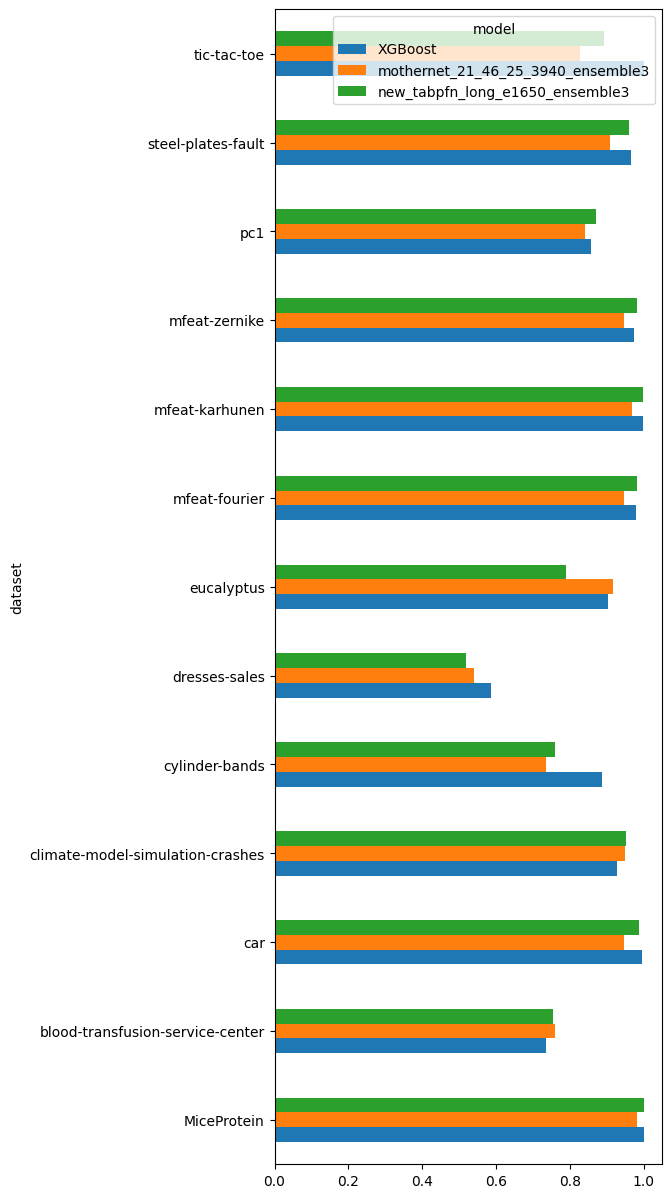

Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a Transformer with 149.66 M parameters
Using cpu device
Using a 

In [55]:
plt.figure(figsize=(5, 15))
different.plot.barh(ax=plt.gca())

In [56]:
cc_test_datasets_multiclass_df.set_index("name")

,did,name,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures,isNumeric
11,11,balance-scale,1,1,active,ARFF,288.0,3.0,49.0,3,5,625,0.0,0.0,4.0,1.0,True
14,14,mfeat-fourier,1,1,active,ARFF,200.0,10.0,200.0,10,77,2000,0.0,0.0,76.0,1.0,True
15,15,breast-w,1,1,active,ARFF,458.0,2.0,241.0,2,10,699,16.0,16.0,9.0,1.0,False
16,16,mfeat-karhunen,1,1,active,ARFF,200.0,10.0,200.0,10,65,2000,0.0,0.0,64.0,1.0,True
18,18,mfeat-morphological,1,1,active,ARFF,200.0,10.0,200.0,10,7,2000,0.0,0.0,6.0,1.0,True
22,22,mfeat-zernike,1,1,active,ARFF,200.0,10.0,200.0,10,48,2000,0.0,0.0,47.0,1.0,True
23,23,cmc,1,1,active,ARFF,629.0,4.0,333.0,3,10,1473,0.0,0.0,2.0,8.0,False
29,29,credit-approval,1,1,active,ARFF,383.0,14.0,307.0,2,16,690,37.0,67.0,6.0,10.0,False
31,31,credit-g,1,1,active,ARFF,700.0,10.0,300.0,2,21,1000,0.0,0.0,7.0,14.0,False
37,37,diabetes,1,1,active,ARFF,500.0,2.0,268.0,2,9,768,0.0,0.0,8.0,1.0,True


In [57]:
from sklearn.datasets import fetch_openml

In [62]:
cylinder_bands = fetch_openml(data_id=6332).frame

In [63]:
cylinder_bands

,customer,job_number,grain_screened,ink_color,proof_on_ctd_ink,blade_mfg,cylinder_division,paper_type,ink_type,direct_steam,...,solvent_pct,ESA_Voltage,ESA_Amperage,wax,hardener,roller_durometer,current_density,anode_space_ratio,chrome_content,band_type
0,tvguide,25503.0,yes,key,yes,benton,gallatin,uncoated,uncoated,no,...,36.4,0.0,0.0,2.5,1.0,34.0,40,105.00,100,band
1,tvguide,25503.0,yes,key,yes,benton,gallatin,uncoated,uncoated,no,...,38.5,0.0,0.0,2.5,0.7,34.0,40,105.00,100,noband
2,modmat,47201.0,yes,key,yes,benton,gallatin,uncoated,coated,no,...,39.8,0.0,0.0,2.8,0.9,40.0,40,103.87,100,noband
3,massey,39039.0,yes,key,yes,benton,gallatin,uncoated,uncoated,no,...,38.8,0.0,0.0,2.5,1.3,40.0,40,108.06,100,noband
4,kmart,37351.0,no,key,yes,benton,gallatin,uncoated,coated,no,...,42.5,5.0,0.0,2.3,0.6,35.0,40,106.67,100,noband
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,kmart,85813.0,NaN,key,NaN,NaN,gallatin,super,uncoated,NaN,...,NaN,NaN,NaN,1.0,1.0,NaN,40,112.50,100,band
536,best,38064.0,NaN,key,NaN,NaN,gallatin,super,coated,NaN,...,NaN,NaN,NaN,0.0,0.0,NaN,40,110.00,100,band
537,kmart,85814.0,NaN,key,NaN,NaN,gallatin,super,coated,NaN,...,NaN,NaN,NaN,2.7,2.8,NaN,40,108.00,100,band
538,kmart,85814.0,NaN,key,NaN,NaN,gallatin,super,uncoated,NaN,...,NaN,NaN,NaN,1.5,2.3,NaN,40,108.00,100,band


In [64]:
asdf = fetch_openml(data_id=6332)

In [66]:
asdf.target_names

['band_type']

In [68]:
cylinder_bands.groupby("job_number").band_type.value_counts().unstack()

,band,noband
job_number,,
23040.0,1,0
23048.0,0,2
23050.0,0,2
23052.0,1,0
23055.0,1,0
...,...,...
85741.0,1,0
85750.0,1,0
85813.0,3,0


In [70]:
tictactoe =  fetch_openml(data_id=50)

In [71]:
tictactoe.frame.columns

Index(['top-left-square', 'top-middle-square', 'top-right-square',
       'middle-left-square', 'middle-middle-square', 'middle-right-square',
       'bottom-left-square', 'bottom-middle-square', 'bottom-right-square',
       'Class'],
      dtype='object')

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
ohe = OneHotEncoder(sparse=False)
X_train, X_test, y_train, y_test = train_test_split(ohe.fit_transform(tictactoe.data), tictactoe.target)

In [83]:
rf = RandomForestClassifier().fit(X_train, y_train)

In [85]:
rf.score(X_test, y_test)

0.9875

<AxesSubplot:>

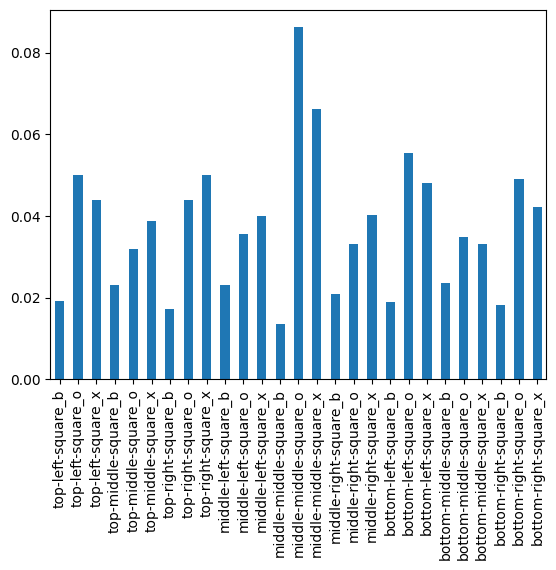

In [89]:
pd.Series(rf.feature_importances_, index=ohe.get_feature_names_out()).plot(kind="bar")